In [1]:
import matplotlib.pyplot as plt
from time import time
from simfunctions import *

import matplotlib as mpl

# Take colors at regular intervals spanning the colormap.
colors = mpl.colormaps['Dark2'].colors

# SIS Model

$$ S + I \to I + I, c_1x_Sx_I $$
$$ S \to I, c_2x_S $$
$$ I \to S, c_3x_I $$
with parameters $c_1 = 0.008, c_2=0.1, c_3 = 0.3$


In [2]:
def rate1(X):
    rate = 0.016*X[0]*X[1]
    if rate > 0:
        return rate
    else:
        return 0

def rate2(X):
    rate = 0.1*X[0]
    if rate > 0:
        return rate
    else:
        return 0
    
def rate3(X):
    rate = 0.5*X[1]
    if rate > 0:
        return rate
    else:
        return 0
    
def jac(X):
    return np.array([[0.008*X[1], 0.008*X[0]], [0.1, 0], [0, 0.5]])

# Example usage:
drift = [rate1, rate2, rate3]
S_matrix = np.array([[-1, 1], [-1, 1], [1, -1]])  # Stoichiometry matrix
c = np.array([1,1,1])  # Reaction rates
X0 = np.array([90, 40])  # Initial state
T = 10  # Total time

## Tau-Leaping

In [3]:
def tau_leaping(drift, S, c, X0, T, tau):
    """
    drift: list of rate functions
    S: Stoichiometry matrix. Each row represents a reaction, and each column represents a species.
    c: Array of reaction rates.
    X0: Initial state.
    T: Total time.
    tau: Leap size.
    """
    steps = int(np.ceil(T/tau))
    K_list = []
    X = []
    t = []
    t0 = 0.
    X.append(X0)
    t.append(t0)
    
    for j in range(steps):
        a = c*np.array([rate(X[j]) for rate in drift])  # Propensity function
        K = np.random.poisson(a*tau)  # Number of reactions
        K_list.append(K)
        X_new = X[j] + np.dot(K, S)  # Update the state
        X.append(X_new)
        t.append(t[j]+tau)

        # Check for negative populations
        if np.any(X[j+1] < 0):
            print('Negative population, restarting run')
            return None, t
        
    return X, t, K_list

0.0 % simulations completed
10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed
70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed
Number of steps:  51


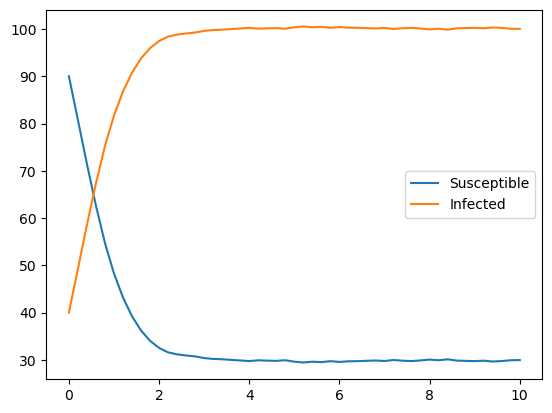

In [4]:
tau = 0.2  # Leap size

n_runs = 1000
runs = []
k_runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau, K_list = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
    k_runs.append(K_list)
    
print('Number of steps: ', len(X))

Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)

plt.plot(t_tau, Xs, label='Susceptible')
plt.plot(t_tau, Xi, label='Infected')
plt.legend()

In [5]:
k_last = []

k1_list = []
k2_list = []
k1k2_list = []

for k_run in k_runs:
    k_last.append(k_run[-1])
    
for i in range(len(k_last)):
    k1 = k_last[0]
    k2 = k_last[1]
    k1_list.append(k1)
    k2_list.append(k2)
    k1k2_list.append(k1*k2)
    
np.mean(k1), np.mean(k2), np.mean(k1*k2)-np.mean(k1)*np.mean(k2)

(7.666666666666667, 6.333333333333333, 14.444444444444443)

## Mean-field

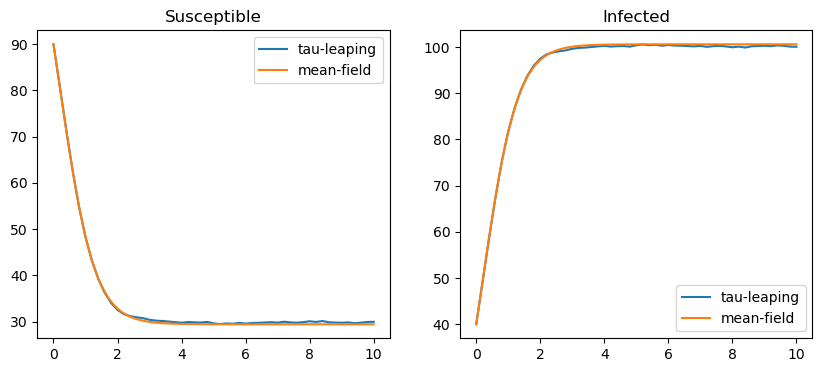

In [6]:
tmf = np.linspace(0,T, 100)
Xmf = mean_field(drift,S_matrix,c,X0,tmf)

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field')
axs[1].set_title('Infected')
axs[1].legend()

## SOGA - Gaussian Approximation

In [8]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/Factorized_SIS.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist, fact_dynams = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

input 12.694264334232647 0.40881303003753583
fit with neural network [[12.42895846]] [[4.10098732]] [[16.81809702]]
analytical fit 12.694264334232425 12.861392427756357
input 1.6109426407629845 0.08081851505849807
fit with neural network [[1.44258088]] [[1.57266024]] [[2.47326022]]
analytical fit 1.610942640762984 1.6174742731392455
input 4.945286796185078 0.4040925752924903
fit with neural network [[5.12122029]] [[2.71868389]] [[7.39124207]]
analytical fit 4.945286796185078 5.108577605591584
input 13.292275872120449 0.277338419865289
fit with neural network [[12.57840199]] [[4.14633182]] [[17.19206758]]
analytical fit 13.292275872119678 13.369192471236005
input 1.4202904181978047 0.1183035556301729
fit with neural network [[1.25371614]] [[1.49455193]] [[2.23368548]]
analytical fit 1.4202904181978049 1.4342861494725465
input 5.8985479090109765 0.5915177781508645
fit with neural network [[5.97957048]] [[2.9294428]] [[8.58163509]]
analytical fit 5.898547909010973 6.248441190879518
input 

C:\Users\birik\github\SOGA4SSA\src\libSOGAupdate.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/poisson_dim1.pth')


fit with neural network [[12.58022323]] [[4.14740663]] [[17.20098173]]
analytical fit 13.314444562074165 13.397275397918293
input 1.2398526105104206 0.14858237203051644
fit with neural network [[1.09527292]] [[1.42568942]] [[2.03259034]]
analytical fit 1.2398526105104208 1.261929331788635
input 6.800736947447897 0.7429118601525792
fit with neural network [[6.73209851]] [[3.07367197]] [[9.44745941]]
analytical fit 6.80073694744789 7.35265497940329
input 12.888389358975116 0.7058772327310086
fit with neural network [[12.43210396]] [[4.10817862]] [[16.87713154]]
analytical fit 12.888389358973996 13.386652026637023
input 1.0800451999326068 0.17484626405909742
fit with neural network [[0.98365444]] [[1.37755137]] [[1.89764777]]
analytical fit 1.0800451999414151 1.1106164159773466
input 7.599774000336964 0.8742313202954896
fit with neural network [[7.52919237]] [[3.22005436]] [[10.36875009]]
analytical fit 7.599774000336965 8.364054401722534
input 12.210414228530542 1.2055134360776079
fit wi

In [10]:
dist = Dist(['x', 'Xnext[0]', 'Xnext[1]', 'y'], GaussianMix([0.5, 0.5], 
                                                           [np.array([0., 0.1, 0.2, 0.3]), np.array([0.1, 0.2, 0.3, 0.4])],
                                                          [np.eye(4), np.eye(4)]))
truncate_state(dist)

C:\Users\birik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\birik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Dist<['x', 'Xnext[0]', 'Xnext[1]', 'y'],pi: [0.24190180641591352, 0.2580981935840865, 0.29806427137710045, 0.20193572862289957] mu: [array([0.        , 1.09503747, 1.351013  , 0.3       ]), array([0.        , 0.55908288, 0.51832468, 0.3       ]), array([0.1       , 0.97581625, 0.51169414, 0.4       ]), array([0.1       , 0.76953508, 1.51810786, 0.4       ])] sigma: [array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.46808988, -0.22002117,  0.        ],
       [ 0.        , -0.22002117,  0.50860065,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.13240888, -0.02593452,  0.        ],
       [ 0.        , -0.02593452,  0.12259482,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.46192262, 0.02917371, 0.        ],
       [0.        , 0.029

In [11]:
t = len(t_tau)

xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    mu, cov = fact_dynams[i]
    xs[i] = mu[2]
    stds[i] = np.sqrt(cov[2,2])
    xi[i] = mu[3]
    stdi[i] = np.sqrt(cov[3,3])

In [12]:
fact_dynams

{0: (array([ 0.,  0., 90., 40.]),
  array([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]])),
 1: (array([90.        , 40.        , 80.54713204, 49.45286796]),
  array([[  0.        ,   0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,  16.32908094, -16.32908094],
         [  0.        ,   0.        , -16.32908094,  16.32908094]])),
 2: (array([80.54713204, 49.45286796, 71.01452091, 58.98547909]),
  array([[ 16.32908094, -16.32908094,  16.32908094, -16.32908094],
         [-16.32908094,  16.32908094, -16.32908094,  16.32908094],
         [ 16.32908094, -16.32908094,  34.98932819, -34.98932819],
         [-16.32908094,  16.32908094, -34.98932819,  34.98932819]])),
 3: (array([71.01452091, 58.98547909, 61.99263053, 68.00736947]),
  array([[ 34.98932819, -34.98932819,  34.98932819, -34.98932819],
         [-34.98932819,  34.98932819, -34.989328

Text(0, 0.5, 'Number of individuals')

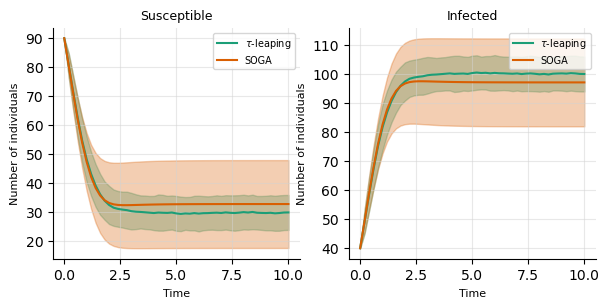

In [13]:
# conditioning on state

fig, axs = plt.subplots(1,2, figsize=(7,3))

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
#axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
#axs[0].axhline(0)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
#axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
#axs[1].axhline(0)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)



### Joint on K

In [11]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/Factorized_SIS_joint.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist, fact_dynams = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

Computed in 4.84s


In [12]:
t = len(t_tau)

xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    mu, cov = fact_dynams[i]
    xs[i] = mu[2]
    stds[i] = np.sqrt(cov[2,2])
    xi[i] = mu[3]
    stdi[i] = np.sqrt(cov[3,3])

Text(0, 0.5, 'Number of individuals')

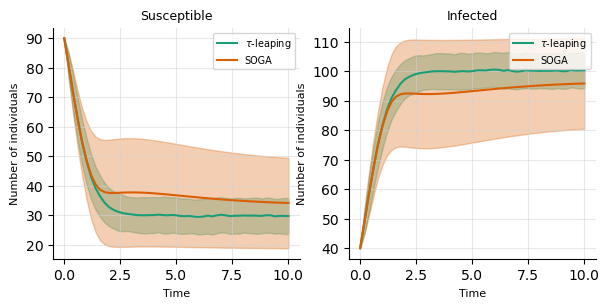

In [13]:
# conditioning on state

fig, axs = plt.subplots(1,2, figsize=(7,3))

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
#axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
#axs[0].axhline(0)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
#axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
#axs[1].axhline(0)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)